<a href="https://colab.research.google.com/github/MajorRedux/PatternFlow/blob/topic-recognition/recognition/OAI_AKOA_DCGAN_s4577741/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Report - OAI AKOA knee data set using DCGAN**

In [1]:
# data importing
import sys
import numpy as np
import os, time
from matplotlib import pyplot as plt
import random
# import images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# loading bar
from tqdm.auto import tqdm
# models
from keras.optimizers import Nadam
from tensorflow.keras import datasets, layers, models

# Connect to GDrive to acquire data
from google.colab import drive

# Connect to drive, change path
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/data/AKOA_Analysis

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/data/AKOA_Analysis


In [ ]:
# Parameters
## data directory
data_dir = "/content/gdrive/My Drive/Colab Notebooks/data/AKOA_Analysis"
## training set size
train_n = 900
## testing set size
test_n = 180 # 20/80 rule
## image names
imgs_nms = np.sort(os.listdir(data_dir))
## display data 
print("Data Directory:", data_dir)
print("Images:", len(imgs_nms))
## names of image files for training set
train_imgs_nms = imgs_nms[:train_n]
## names of image files for testing data
test_imgs_nms = imgs_nms[train_n:train_n + test_n]
## image shape
img_shape = (260, 228, 1)

## optimizer
### standard parameters - learning rate 0.0002 gives good results
_optimizer = Nadam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
_kernel_initializer = 'he_uniform'
_activation = 'selu'

In [5]:
# Data Loading
## Parse image folder to acquire images
def get_data(traing_imgs_nms):
  X_train = []
  for i, img_id in tqdm(enumerate(train_imgs_nms)):
    img = load_img(data_dir + "/" + img_id, target_size=img_shape[:2])
    img = img_to_array(img)/255.0
    X_train.append(img)
  X_train = np.array(X_train)
  return(X_train)

# Training Set
X_train = get_data(train_imgs_nms)
print("X_train.shape = {}".format(X_train.shape))

# Testing Set
X_test  = get_data(test_imgs_nms)
print("X_test.shape = {}".format(X_test.shape))


X_train.shape = (1800, 260, 228, 3)



X_test.shape = (1800, 260, 228, 3)


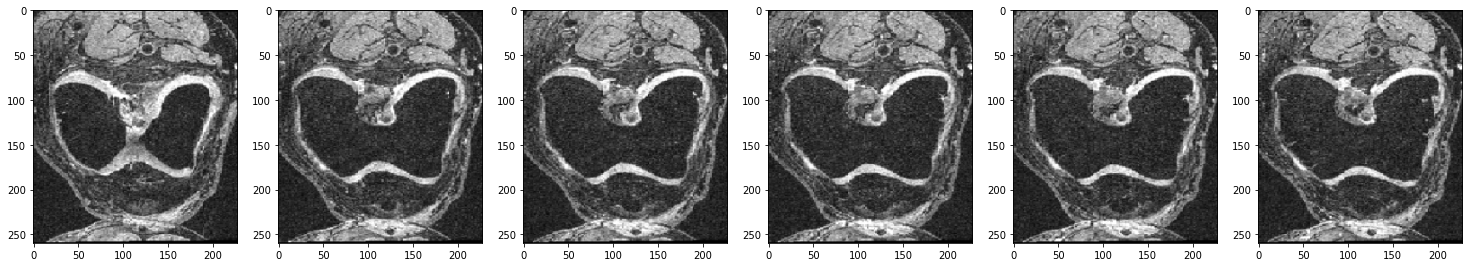

In [6]:
# Data Checking
## Check data and plot resized input images
fig = plt.figure(figsize=(30,10))
nplot = 7
for count in range(1,nplot):
    ax = fig.add_subplot(1, nplot,count)
    ax.imshow(X_train[count])
plt.show()

In [7]:
# Generator generates new data instances that are similar to training data. Generator takes random latent vector and outputs fake image of the same size as reshaped AKOA image
def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''

    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    net = layers.Dense(256, activation=_activation, kernel_initializer=_kernel_initializer)(input_noise)
    #net = layers.Dense(256, activation=_activation, kernel_initializer=_kernel_initializer)(input_noise) 
    net = layers.Dense(1*65*57, activation=_activation)(net)
    net = layers.Reshape((65,57,1))(net)
    
    net = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(net)
    net = layers.Conv2D( 16  , ( 1 , 1 ) , activation=_activation, kernel_initializer=_kernel_initializer , padding='same', name="block_4_1", dilation_rate=(1, 1))(net) ## 16,16
    net = layers.Conv2D( 16  , ( 1 , 1 ) , activation=_activation, kernel_initializer=_kernel_initializer , padding='same', name="block_4_2", dilation_rate=(2, 2))(net) ## 16,16

    net = layers.Conv2DTranspose(64, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(net)
    net = layers.Conv2D( 32  , ( 1 , 1 ) , activation=_activation, kernel_initializer=_kernel_initializer , padding='same', name="block_5_1", dilation_rate=(1, 1))(net) ## 32,32
    net = layers.Conv2D( 32  , ( 1 , 1 ) , activation=_activation, kernel_initializer=_kernel_initializer , padding='same', name="block_5_2", dilation_rate=(2, 2))(net) ## 32,32

    if img_shape[0] == 64:
        net = layers.Conv2DTranspose(64, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(net)
        net = layers.Conv2D( 64  , ( 1 , 1 ) , activation=_activation, kernel_initializer=_kernel_initializer , padding='same', name="block_8_1", dilation_rate=(1, 1))(net) ## 64,64
        net = layers.Conv2D( 64  , ( 1 , 1 ) , activation=_activation, kernel_initializer=_kernel_initializer , padding='same', name="block_8_2", dilation_rate=(2, 2))(net) ## 64,64
    
    img = layers.Conv2D( 3 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")(net) ## 32, 32
    model = models.Model(input_noise, img)
    model.summary() 
    return(model)

In [8]:
# Set the dimension of latent variables to be 100
noise_shape = (100,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=_optimizer)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 3705)              952185    
_________________________________________________________________
reshape (Reshape)            (None, 65, 57, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 130, 114, 128)     512       
_________________________________________________________________
block_4_1 (Conv2D)           (None, 130, 114, 16)      2064      
_________________________________________________________________
block_4_2 (Conv2D)           (None, 130, 114, 16)     

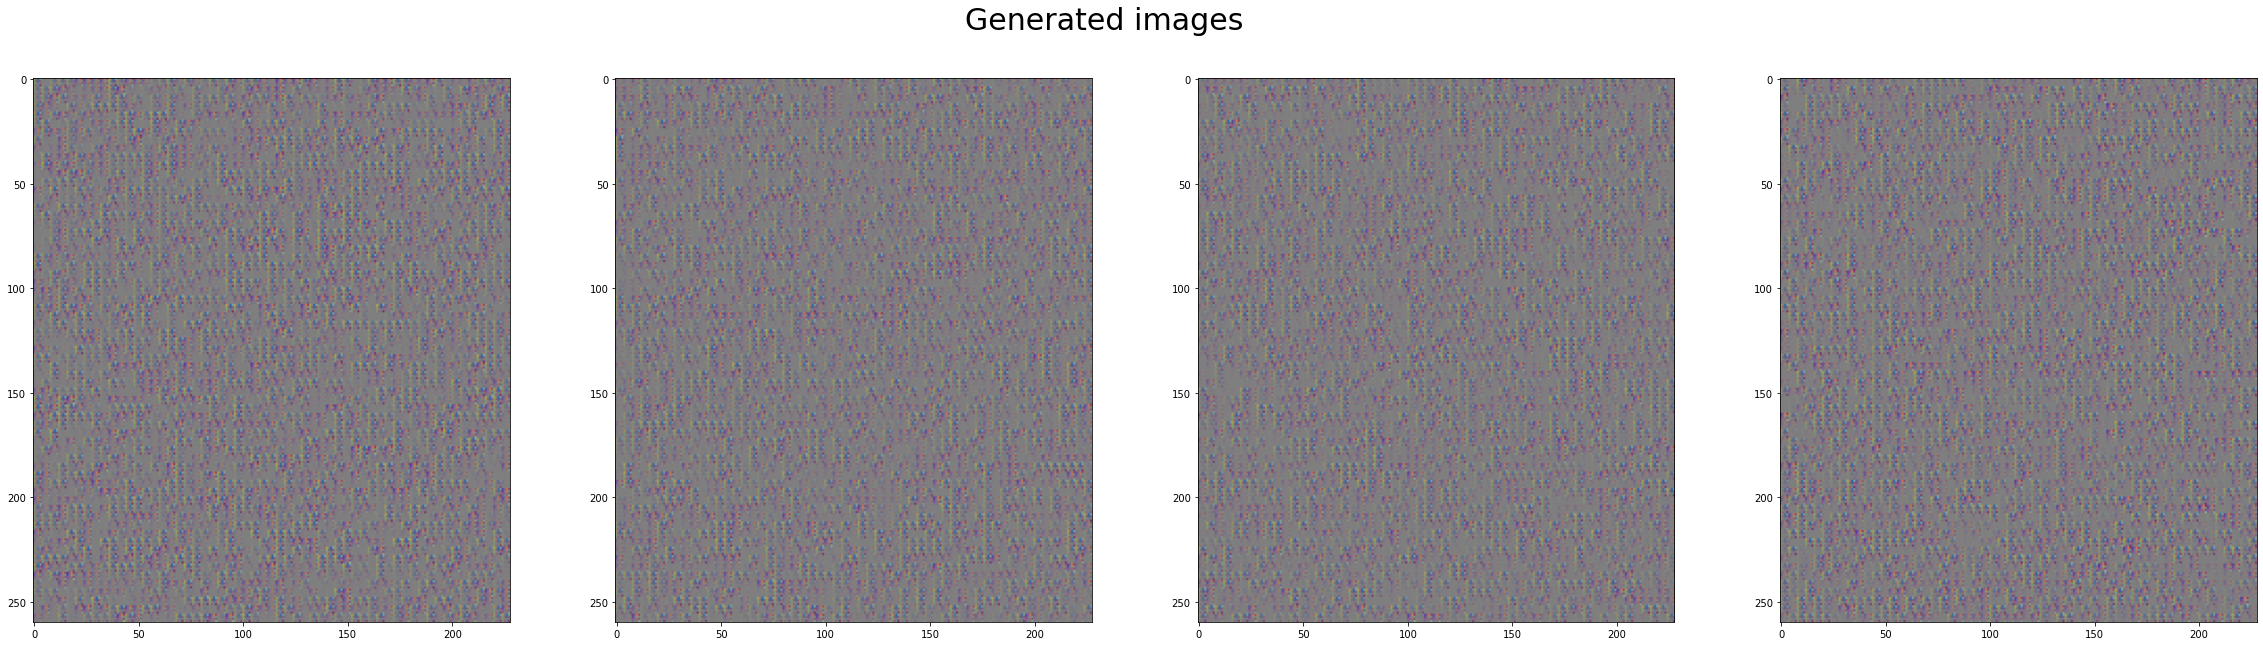

In [9]:
# Generate noise
def get_noise(nsample=1, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample,nlatent_dim))
    return(noise)

# Plot generated images
def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 4
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

In [13]:
# Discriminator evaluates authenticity of provided images and classifies the images from the generator and the original image. Discriminator takes true or fake images and ouputs probability estimate ranging between 0 and 1.
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    # Discriminate shapes
    net = layers.Conv2D(16, (3, 3), activation=_activation, padding='same', kernel_initializer=_kernel_initializer, name='block1_conv1', dilation_rate=(1, 1))(input_img)
    net = layers.Conv2D(16, (3, 3), activation=_activation, padding='same', kernel_initializer=_kernel_initializer, name='block1_conv2', dilation_rate=(2, 2))(net)
    
    # Discriminate edges
    net = layers.Conv2D(32, (3, 3), activation=_activation, padding='same', kernel_initializer=_kernel_initializer, name='block2_conv1', dilation_rate=(1, 1))(net)
    net = layers.Conv2D(32, (3, 3), activation=_activation, padding='same', kernel_initializer=_kernel_initializer, name='block2_conv2', dilation_rate=(2, 2))(net)
    
    # Discriminate objects
    net = layers.Conv2D(64, (3, 3), activation=_activation, padding='same', kernel_initializer=_kernel_initializer, name='block3_conv1', dilation_rate=(1, 1))(net)
    net = layers.Conv2D(64, (3, 3), activation=_activation, padding='same', kernel_initializer=_kernel_initializer, name='block3_conv2', dilation_rate=(2, 2))(net)

    
    net         = layers.Flatten()(net)
    net         = layers.Dense(256, activation=_activation)(net)
    #net         = layers.Dense(256, activation=_activation)(net)
    out       = layers.Dense(noutput,   activation='sigmoid')(net)
    model     = models.Model(input_img, out)
    
    return model

discriminator  = build_discriminator(img_shape)
discriminator.compile(loss      = 'binary_crossentropy', 
                      optimizer = _optimizer,
                      metrics   = ['accuracy'])

discriminator.summary()

ResourceExhaustedError: ignored